This notebook addresses following problems
1. The dataset from Home Credit has imbalance data - i.e 282686 datapoints belongs to non-defaulters group and only 24825 to defaulters. Address the imbalance data with Undersampling the majority class.
2. The goal is to help finanacial institution to make decision to issue loan such that risk is lowered and at the same time find potential customers who can repay loan. In order to find both of these, find  threshold that balance the tradeoff between accurately predicting tge good customers and defaulters.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import ensemble
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

pd.options.display.max_rows = 4000
from imblearn.under_sampling import RandomUnderSampler

# !pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1-dXRO1eJTr2xMo92zEt4Cg66KRpeG7Od/view'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('home_loan.csv') 
 
df = pd.read_csv('home_loan.csv')
df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


0    282686
1     24825
Name: TARGET, dtype: int64

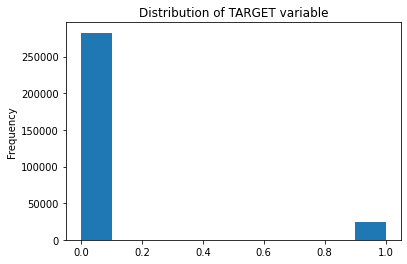

In [4]:
# Target variable (1 - client with payment difficulties: he/she had late payment more than X days, 0 - non-defaulters)
df['TARGET'].astype(int).plot.hist();
plt.title("Distribution of TARGET variable")
df['TARGET'].value_counts()

# EDA

In [5]:
missing_values = df.isnull().sum()*100/df.isnull().count()
missing_values.sort_values(ascending=False)
# missing_values.sort_values(ascending=False).index.values.tolist()

COMMONAREA_MEDI                 69.872297
COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
NONLIVINGAPARTMENTS_MEDI        69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_AVG            68.354953
LIVINGAPARTMENTS_MEDI           68.354953
FLOORSMIN_AVG                   67.848630
FLOORSMIN_MODE                  67.848630
FLOORSMIN_MEDI                  67.848630
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MEDI                   59.376738
LANDAREA_MODE                   59.376738
LANDAREA_AVG                    59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
EXT_SOURCE_1                    56

In [6]:
# drop rows

df = df.dropna(subset=['EXT_SOURCE_3', 
 'EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE'])


In [7]:
# drop columns
df = df.drop(['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE',
 'OWN_CAR_AGE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'ELEVATORS_MODE',
 'ELEVATORS_MEDI',
 'ELEVATORS_AVG',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'LIVINGAREA_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'HOUSETYPE_MODE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'TOTALAREA_MODE',
 'EMERGENCYSTATE_MODE', 'NAME_TYPE_SUITE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',],axis=1)

In [8]:
df["OCCUPATION_TYPE"].fillna("Unknown", inplace = True)

In [9]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # Train on the training data
            le.fit(df[col])
            # Transform data
            df[col] = le.transform(df[col])
            print(col)
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
3 columns were label encoded.


In [10]:
# one-hot encoding of categorical variables
df = pd.get_dummies(df)

print('Training Features shape: ', df.shape)


Training Features shape:  (245895, 164)


In [11]:
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

In [12]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]

print(to_drop)

['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_6', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Unknown', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_XNA']


<ipython-input-12-024b7d4af5e6>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [13]:
X1 = X.drop(to_drop, axis=1)
print(X1.head())

   NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                   0             0                1             0   
2                   1             1                1             0   
5                   0             0                1             0   
6                   0             1                1             1   
7                   0             1                1             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0          202500.0    406597.5                    0.018801       -9461   
2           67500.0    135000.0                    0.010032      -19046   
5           99000.0    490495.5                    0.035792      -16941   
6          171000.0   1560726.0                    0.035792      -13778   
7          360000.0   1530000.0                    0.003122      -18850   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  ORGANIZATION_TYPE_Trade: type 3  \
0            -3648.0            -2120  ...       

In [14]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_rus, y_rus = undersample.fit_resample(X1, y)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=42)

In [16]:
lr = LogisticRegression(solver='lbfgs', random_state=42, max_iter=10000)
lr.fit(x_train, y_train)
lr_cv_scores = cross_val_score(lr, x_train, y_train, cv=5)
print('Accuracy scores for the 5 folds: ', lr_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(lr_cv_scores)))
print('Accuracy score on test set', lr.score(x_test, y_test))
predictions = lr.predict(x_test)

Accuracy scores for the 5 folds:  [0.52274215 0.54050074 0.52315497 0.52299133 0.52511864]
Mean cross validation score: 0.527
Accuracy score on test set 0.5269633507853403


// From the train and test accuracy, it looks like model doesn't overfit on training set

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[2688 1123]
 [2491 1338]]


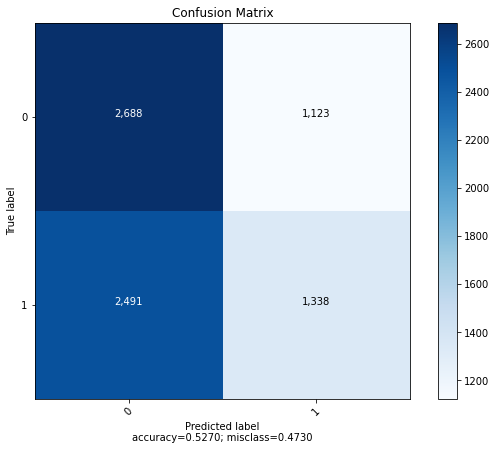

Accuracy score: 0.53
Precision score: 0.54
Recall score: 0.35
F1 score: 0.43
Fbeta score favoring precision: 0.49
FBeta score favoring recall: 0.38
              precision    recall  f1-score   support

           0       0.52      0.71      0.60      3811
           1       0.54      0.35      0.43      3829

    accuracy                           0.53      7640
   macro avg       0.53      0.53      0.51      7640
weighted avg       0.53      0.53      0.51      7640



In [18]:
confusion = confusion_matrix(y_test, predictions, labels=[0, 1])
print(confusion)
plot_confusion_matrix(cm=confusion, target_names = [0, 1], title = 'Confusion Matrix',normalize=False)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
fbeta_precision = fbeta_score(y_test, predictions, beta=0.5)
fbeta_recall = fbeta_score(y_test, predictions, beta=2)



print('Accuracy score: {:.2f}'.format(accuracy))
print('Precision score: {:.2f}'.format(precision))
print('Recall score: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

report = classification_report(y_test, predictions, target_names=['0', '1'])
print(report)

area under roc curve 0.5438918927142423


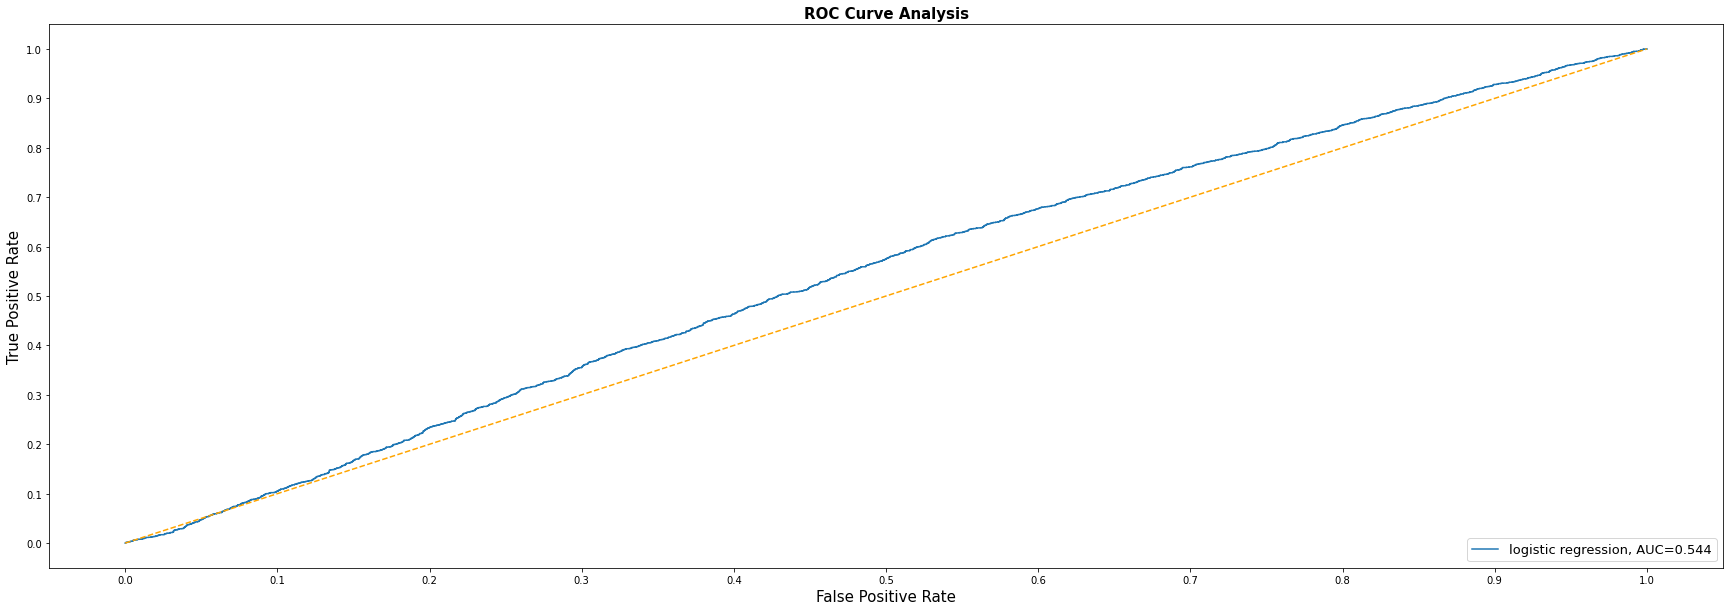

In [21]:
probs = lr.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  probs)
auc = roc_auc_score(y_test, probs)
print("area under roc curve", roc_auc_score(y_test, probs))
fig = plt.figure(figsize=(30,10))

plt.plot(fpr, tpr, label="{}, AUC={:.3f}".format("logistic regression", auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()


In [22]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, criterion = "entropy", max_depth=4, random_state = 42, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(x_train, y_train)
rf_cv_scores = cross_val_score(random_forest, x_train, y_train, cv=5)
print('Accuracy scores for the 5 folds: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))
print('Accuracy score on test set', random_forest.score(x_test, y_test))
predictions = random_forest.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent wor

Accuracy scores for the 5 folds:  [0.66606675 0.67861234 0.67713958 0.66732122 0.67893962]
Mean cross validation score: 0.674
Accuracy score on test set 0.6662303664921466


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [23]:
# Extract feature importances
features = list(x_train.columns)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [24]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

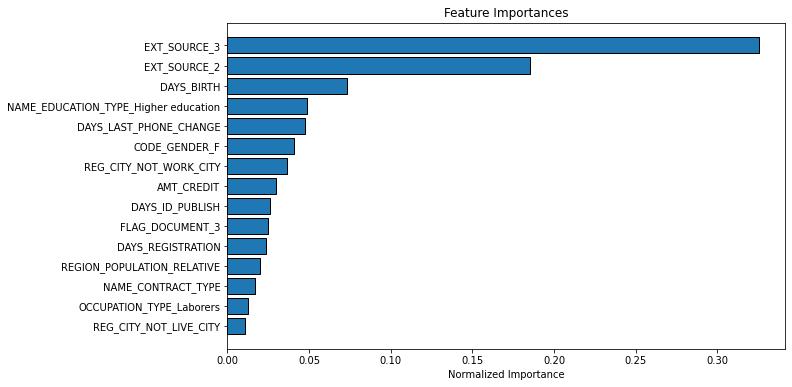

In [25]:
feature_importances = plot_feature_importances(feature_importances)


[[2576 1235]
 [1315 2514]]


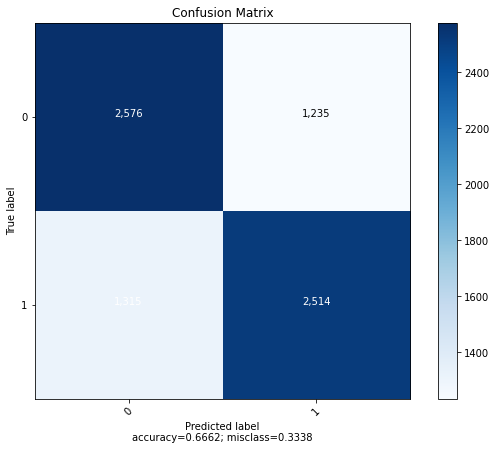

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3811
           1       0.67      0.66      0.66      3829

    accuracy                           0.67      7640
   macro avg       0.67      0.67      0.67      7640
weighted avg       0.67      0.67      0.67      7640



In [26]:
# Make predictions on the test data
confusion = confusion_matrix(y_test, predictions, labels=[0, 1])
print(confusion)
plot_confusion_matrix(cm=confusion, target_names = [0, 1], title = 'Confusion Matrix',normalize=False)

report = classification_report(y_test, predictions, target_names=['0', '1'])
print(report)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


area under roc curve 0.7216909114993991


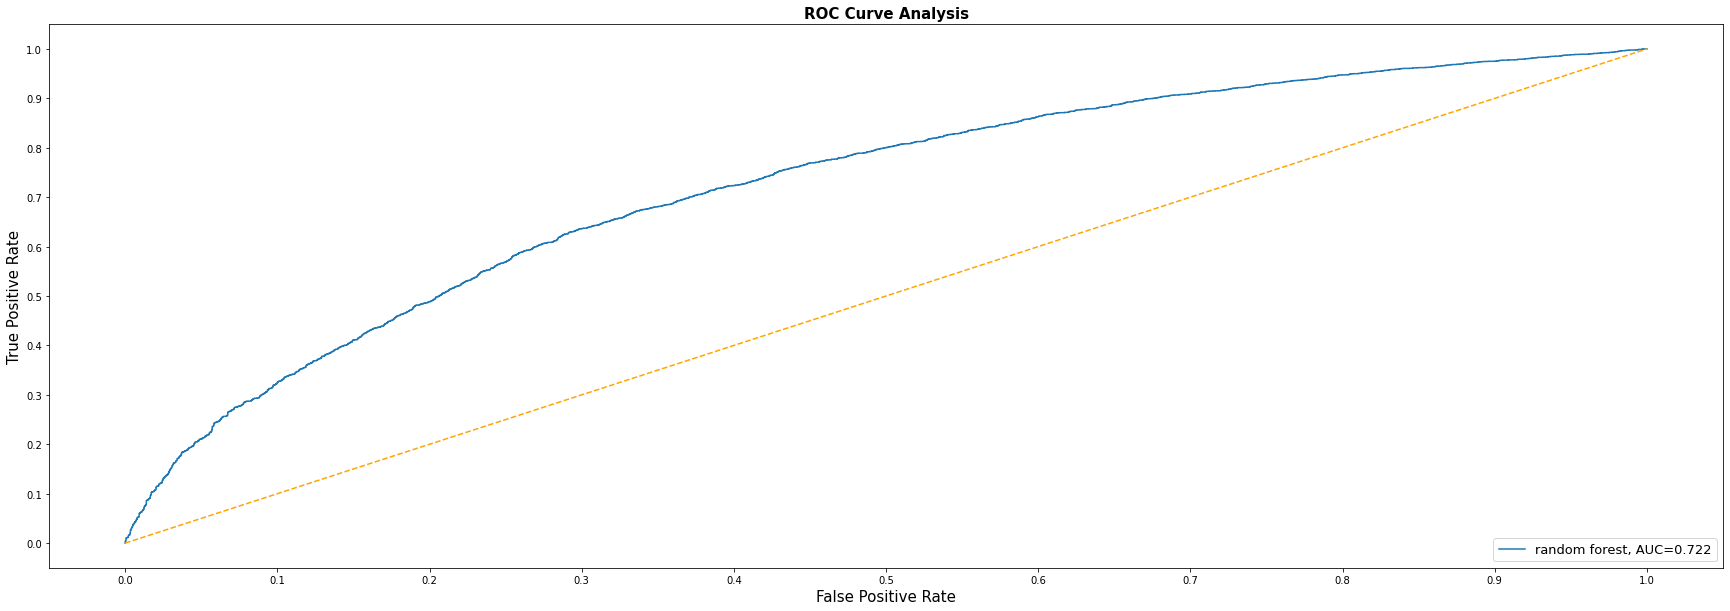

In [59]:
probs = random_forest.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,  probs)
auc = roc_auc_score(y_test, probs)
print("area under roc curve", roc_auc_score(y_test, probs))
fig = plt.figure(figsize=(30,10))

plt.plot(fpr, tpr, label="{}, AUC={:.3f}".format("random forest", auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()


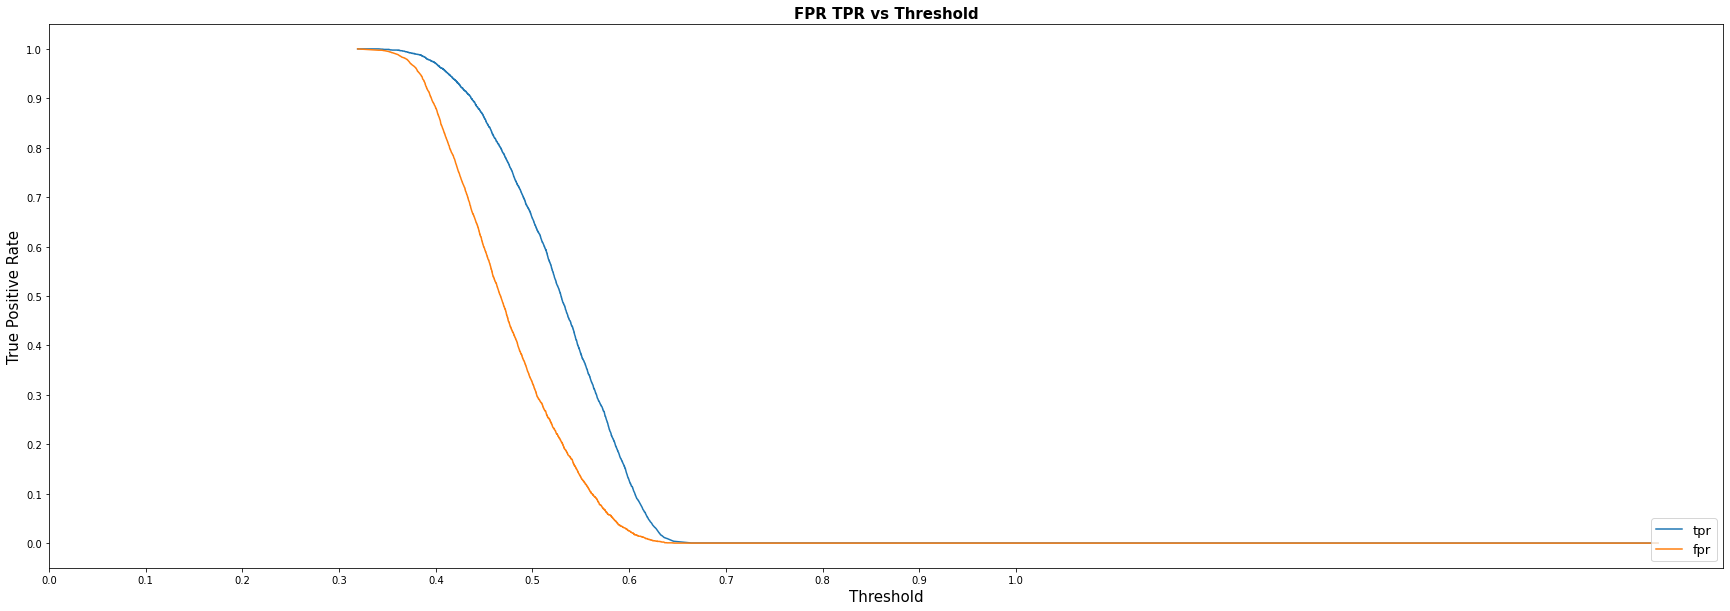

In [60]:
fig = plt.figure(figsize=(30,10))

plt.plot(thresholds, tpr, label="{}".format("tpr"))
plt.plot(thresholds, fpr, label="{}".format("fpr"))

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Threshold", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('FPR TPR vs Threshold', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [65]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

[[2576 1235]
 [1315 2514]]


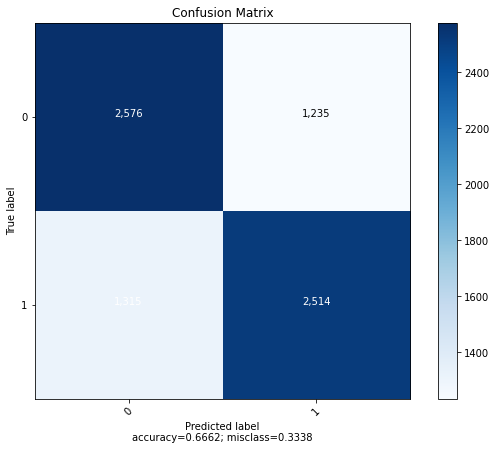

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3811
           1       0.67      0.66      0.66      3829

    accuracy                           0.67      7640
   macro avg       0.67      0.67      0.67      7640
weighted avg       0.67      0.67      0.67      7640



In [73]:
y_pred_adj = adjusted_classes(probs, 0.5)
confusion = confusion_matrix(y_test, y_pred_adj, labels=[0, 1])
print(confusion)
plot_confusion_matrix(cm=confusion, target_names = [0, 1], title = 'Confusion Matrix',normalize=False)

report = classification_report(y_test, y_pred_adj, target_names=['0', '1'])
print(report)

In [29]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
gbm = ensemble.GradientBoostingClassifier(**params)
gbm.fit(x_train, y_train)

predictions = gbm.predict(x_test)

[[2594 1217]
 [1287 2542]]


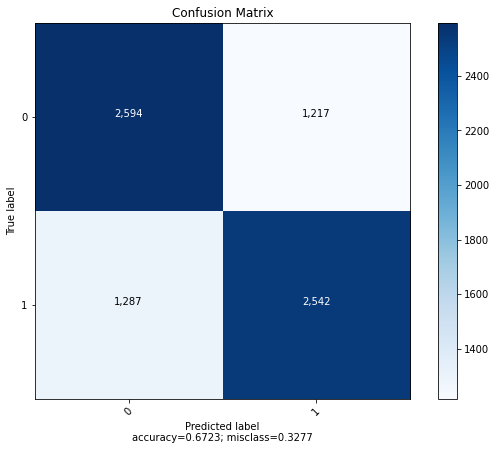

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      3811
           1       0.68      0.66      0.67      3829

    accuracy                           0.67      7640
   macro avg       0.67      0.67      0.67      7640
weighted avg       0.67      0.67      0.67      7640



In [30]:
# Make predictions on the test data
confusion = confusion_matrix(y_test, predictions, labels=[0, 1])
print(confusion)
plot_confusion_matrix(cm=confusion, target_names = [0, 1], title = 'Confusion Matrix',normalize=False)

report = classification_report(y_test, predictions, target_names=['0', '1'])
print(report)

In [47]:
probs = gbm.predict_proba(x_test)[:, 1]
probs

array([0.56174638, 0.80897347, 0.21860822, ..., 0.67647392, 0.79897365,
       0.16481967])

area under roc curve 0.7318886052312864


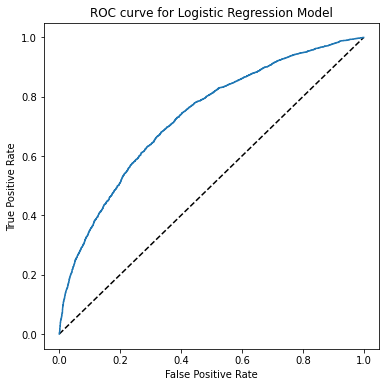

In [44]:

fpr, tpr, thresholds = roc_curve(y_test, probs)
print("area under roc curve", roc_auc_score(y_test, probs))

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

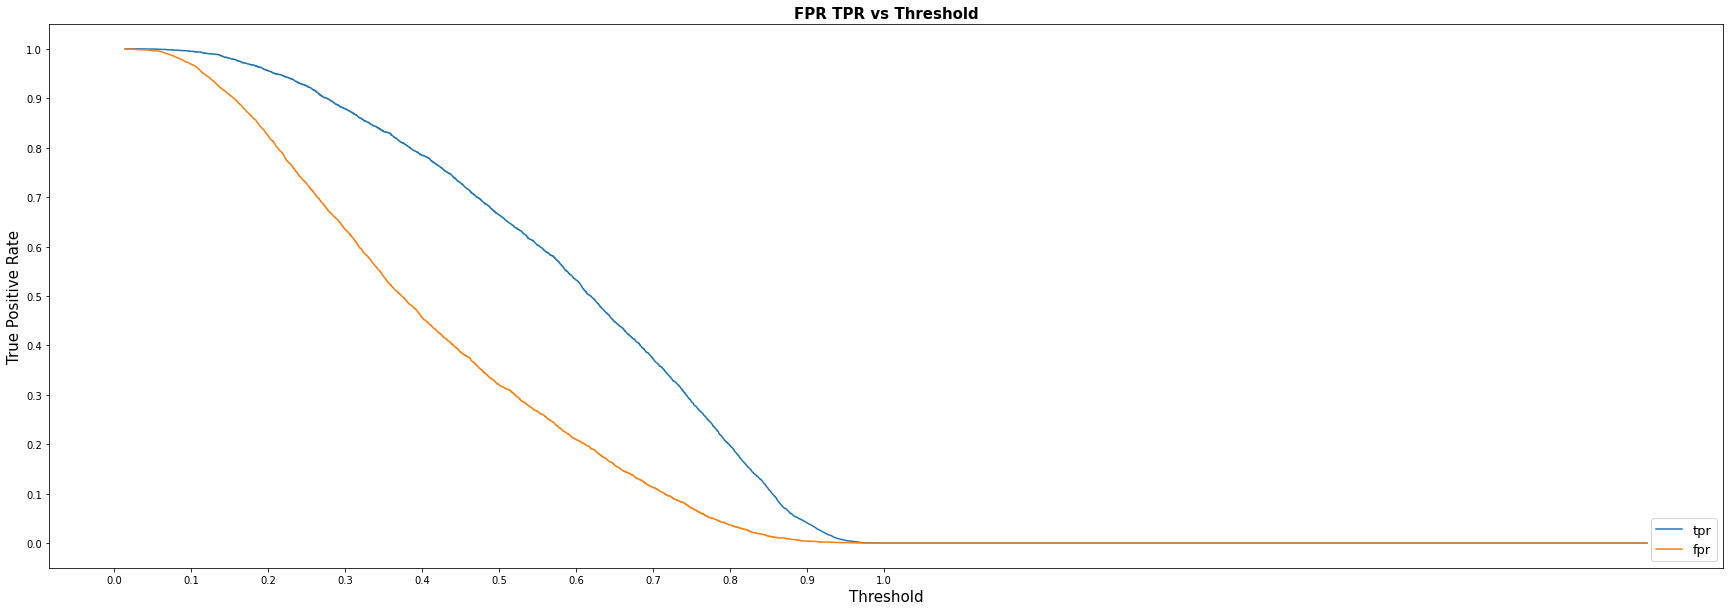

In [51]:
fig = plt.figure(figsize=(30,10))

plt.plot(thresholds, tpr, label="{}".format("tpr"))
plt.plot(thresholds, fpr, label="{}".format("fpr"))

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Threshold", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('FPR TPR vs Threshold', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()



[[3811    0]
 [3829    0]]


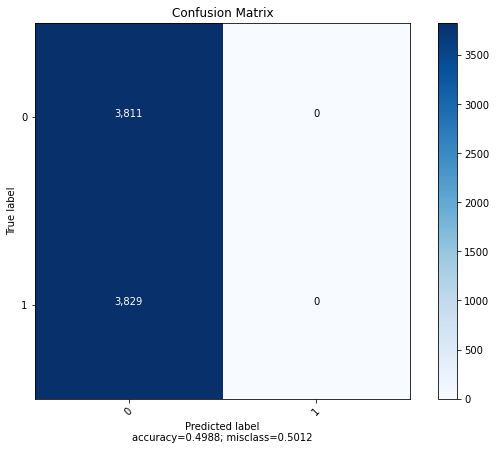

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3811
           1       0.00      0.00      0.00      3829

    accuracy                           0.50      7640
   macro avg       0.25      0.50      0.33      7640
weighted avg       0.25      0.50      0.33      7640



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
y_pred_adj = adjusted_classes(probs, 0.55)

confusion = confusion_matrix(y_test, y_pred_adj, labels=[0, 1])
print(confusion)
plot_confusion_matrix(cm=confusion, target_names = [0, 1], title = 'Confusion Matrix',normalize=False)

report = classification_report(y_test, y_pred_adj, target_names=['0', '1'])
print(report)

In [58]:

# efs1 = ExhaustiveFeatureSelector(RandomForestClassifier(), 
#            min_features=1,
#            max_features=140,
#            scoring='roc_auc',
#            cv=5)

# efs1 = efs1.fit(X1, y)

# print('Best accuracy score: %.2f' % efs1.best_score_)
# print('Best subset (indices):', efs1.best_idx_)
# print('Best subset (corresponding names):', efs1.best_feature_names_)

# Conclusion

Looks like random forest classifier with AUC score of 0.722 performed well coming up with a balance tradeoff between number of defaulters identified and number of customers who can repay loan with which profit can be maximised.

Next steps

More feature engineering like selecting features by 
  1. deal with missing values EXT_SOURCE_1 - one way is to impute with mean of EXT_SOURCE_2 and EXT_SOURCE_3
  2. handling missing values in EXT_SOURCE_2 and EXT_SOURCE_3(impute ext2 with avg(ext1+ext3 if ext1 or ext3 else remove row, ..ly with ext3)
  3. look for significant r/nship in feature for target 0 and 1
  